Saving jepg image.jpeg to jepg image.jpeg


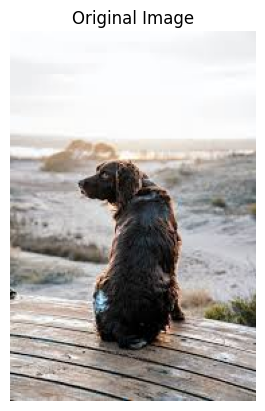

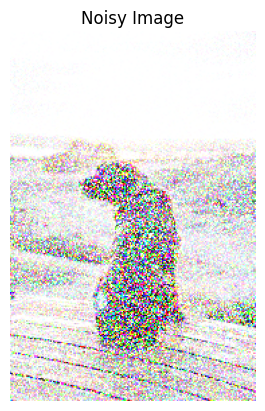

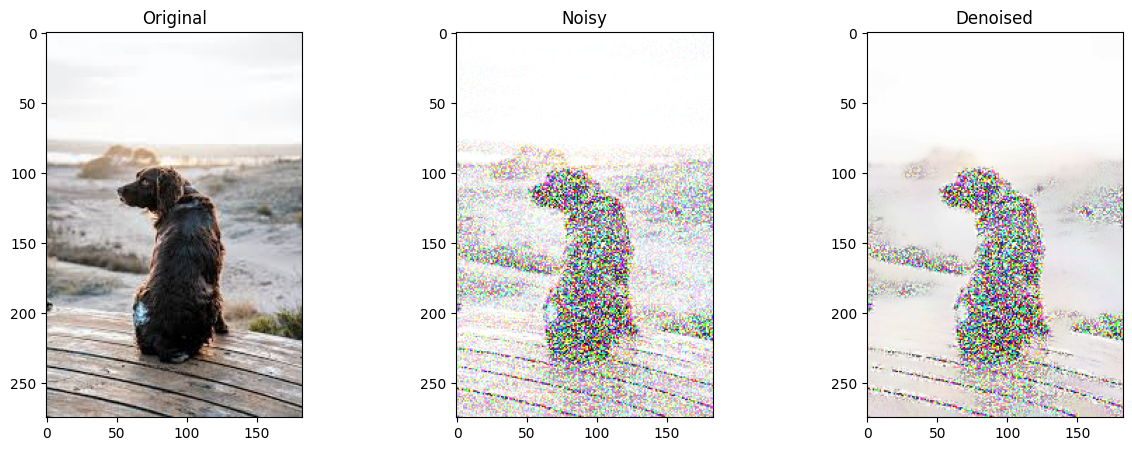

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import files

# Upload an image
uploaded = files.upload()
image_path = next(iter(uploaded))
img = cv2.imread(image_path)

# Convert to RGB for display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title('Original Image')
plt.axis('off')
plt.show()

# Add some synthetic noise to the image (skip this if your uploaded image already has noise)
noisy_img = img.copy()
noise = np.random.normal(0, 25, img.shape).astype(np.uint8)
noisy_img = cv2.add(img, noise)

plt.imshow(cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB))
plt.title('Noisy Image')
plt.axis('off')
plt.show()

# Denoising using OpenCV's fastNlMeansDenoisingColored
denoised_img = cv2.fastNlMeansDenoisingColored(noisy_img, None, 10, 10, 7, 21)

# Display results
plt.figure(figsize=(15, 5))
plt.subplot(131), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Original')
plt.subplot(132), plt.imshow(cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB)), plt.title('Noisy')
plt.subplot(133), plt.imshow(cv2.cvtColor(denoised_img, cv2.COLOR_BGR2RGB)), plt.title('Denoised')
plt.show()


Upload at least 2 overlapping images for panorama stitching:


Saving Screenshot 2025-04-22 120939.png to Screenshot 2025-04-22 120939.png
Saving Screenshot 2025-04-22 120949.png to Screenshot 2025-04-22 120949.png


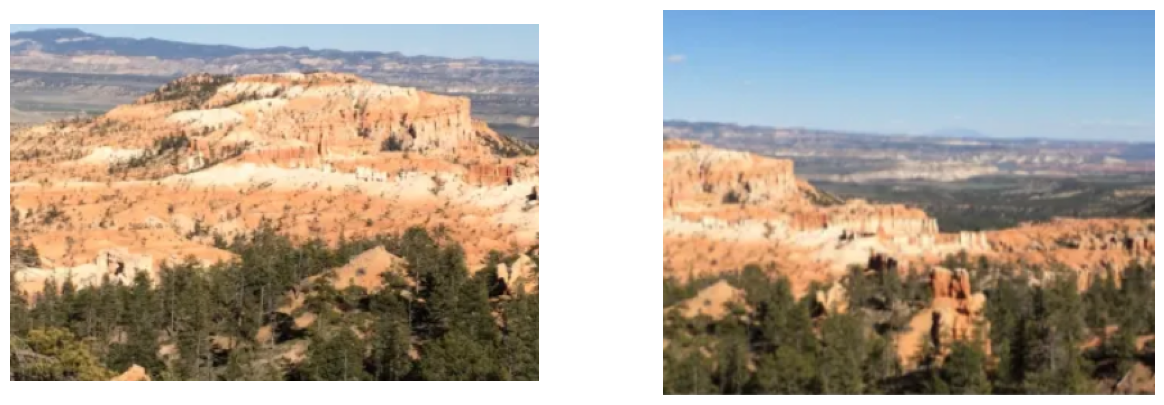

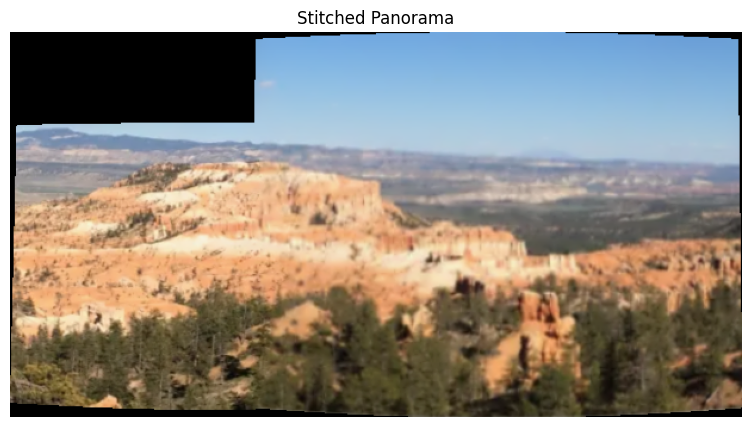

In [ ]:
# Upload multiple overlapping images for panorama
print("Upload at least 2 overlapping images for panorama stitching:")
uploaded = files.upload()
image_paths = list(uploaded.keys())

# Read and display the uploaded images
images = []
plt.figure(figsize=(15, 5))
for i, path in enumerate(image_paths, 1):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)
    plt.subplot(1, len(image_paths), i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

# Stitch images using OpenCV's Stitcher class
stitcher = cv2.Stitcher_create()
(status, stitched_img) = stitcher.stitch(images)

if status == cv2.Stitcher_OK:
    plt.figure(figsize=(10, 5))
    plt.imshow(stitched_img)
    plt.title('Stitched Panorama')
    plt.axis('off')
    plt.show()
else:
    print(f"Stitching failed (status: {status})")


Upload two images of the same scene from slightly different viewpoints:


Saving Screenshot 2025-04-22 121453.png to Screenshot 2025-04-22 121453.png
Saving Screenshot 2025-04-22 121516.png to Screenshot 2025-04-22 121516.png


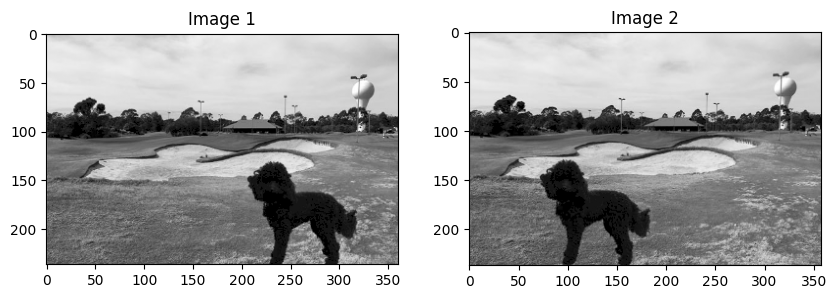

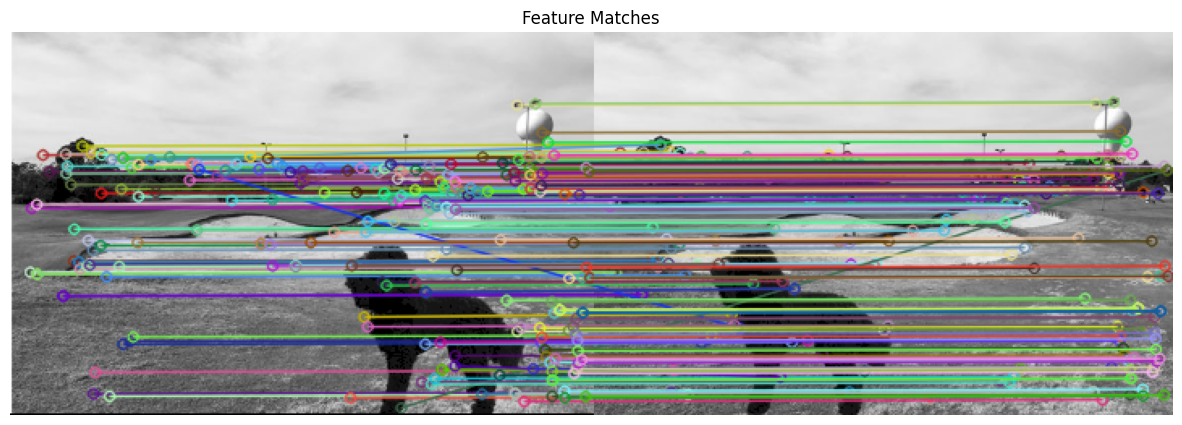

Fundamental Matrix:
[[ 1.77774137e-06  5.42652449e-03 -5.43450753e-01]
 [-5.38914638e-03  7.25700883e-05  1.24089260e+00]
 [ 5.33679526e-01 -1.24514298e+00  1.00000000e+00]]

Essential Matrix:
[[-2.56430892e-04 -6.84399915e-01  3.34781608e-02]
 [ 6.83709314e-01 -6.20230767e-04 -1.77422131e-01]
 [-3.24968652e-02  1.74592170e-01 -8.90312092e-05]]

Rotation Matrix:
[[ 9.99991162e-01 -5.78383231e-04 -4.16441058e-03]
 [ 5.73025663e-04  9.99999007e-01 -1.28759115e-03]
 [ 4.16515116e-03  1.28519345e-03  9.99990500e-01]]

Translation Vector:
[[-0.2468842 ]
 [-0.04609939]
 [-0.96794785]]


In [ ]:
# For SfM, we'll use two images of the same scene from slightly different viewpoints
print("Upload two images of the same scene from slightly different viewpoints:")
uploaded = files.upload()
image_paths = list(uploaded.keys())

if len(image_paths) >= 2:
    img1 = cv2.imread(image_paths[0], cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image_paths[1], cv2.IMREAD_GRAYSCALE)

    # Display the images
    plt.figure(figsize=(10, 5))
    plt.subplot(121), plt.imshow(img1, cmap='gray'), plt.title('Image 1')
    plt.subplot(122), plt.imshow(img2, cmap='gray'), plt.title('Image 2')
    plt.show()

    # Feature detection and matching
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # FLANN based matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Lowe's ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)

    # Draw matches
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(15, 5))
    plt.imshow(img_matches)
    plt.title('Feature Matches')
    plt.axis('off')
    plt.show()

    # Find fundamental matrix
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

    # We select only inlier points
    pts1 = pts1[mask.ravel() == 1]
    pts2 = pts2[mask.ravel() == 1]

    print("Fundamental Matrix:")
    print(F)

    # Find essential matrix (assuming we know the camera intrinsics)
    # In a real scenario, you would calibrate your camera to get these values
    K = np.array([[800, 0, img1.shape[1]/2],
                  [0, 800, img1.shape[0]/2],
                  [0, 0, 1]])

    E = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)[0]
    print("\nEssential Matrix:")
    print(E)

    # Recover pose
    _, R, t, _ = cv2.recoverPose(E, pts1, pts2, K)
    print("\nRotation Matrix:")
    print(R)
    print("\nTranslation Vector:")
    print(t)

else:
    print("Please upload at least 2 images for SfM.")


In [ ]:
# Image Restoration using Autoencoder, GANs on MNIST/CIFAR-10, and MobileNet Comparison

# --- Setup & Imports ---
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.datasets import mnist, cifar10
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage.metrics import peak_signal_noise_ratio as psnr

# --- Step 1: Load & Preprocess Data (MNIST) ---
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# --- Step 2: Simulate Degradation ---
def degrade_images(images):
    noisy = random_noise(images, mode='gaussian', var=0.01)
    blurred = np.array([gaussian(img, sigma=1, channel_axis=-1) for img in noisy])
    return blurred

x_train_noisy = degrade_images(x_train)
x_test_noisy = degrade_images(x_test)

# --- Step 3: Build Autoencoder Model ---
def build_autoencoder():
    input_img = layers.Input(shape=(28, 28, 1))

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return models.Model(input_img, decoded)

autoencoder = build_autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x_train_noisy, x_train, epochs=10, batch_size=128, validation_data=(x_test_noisy, x_test))

# --- Step 5: Evaluate ---
predictions = autoencoder.predict(x_test_noisy)
print("PSNR:", np.mean([psnr(x_test[i], predictions[i]) for i in range(len(x_test))]))

# --- GAN on MNIST & CIFAR-10 ---
# Due to space, this is a basic GAN (can replace with DCGAN/WGAN-GP variants)
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh')
    ])
    return model

def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# Train GAN on MNIST (repeat for CIFAR-10 with changes in model input/output shape)
# Track losses and plot them after training

# --- MobileNet Classification (Dogs Breed) ---
# Requires dataset. Placeholder code for MobileNet comparison
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Small
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

# Assuming images are in 'dogs_breed/' with subfolders as class names
train_gen = datagen.flow_from_directory('dogs_breed', target_size=(224, 224), batch_size=32, class_mode='categorical', subset='training')
val_gen = datagen.flow_from_directory('dogs_breed', target_size=(224, 224), batch_size=32, class_mode='categorical', subset='validation')

def build_mobilenet_model(base_model):
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dense(train_gen.num_classes, activation='softmax')
    ])
    return model

models_to_compare = [MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3)),
                     MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)),
                     MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224,224,3))]

for i, base in enumerate(models_to_compare):
    base.trainable = False
    model = build_mobilenet_model(base)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(f"Training MobileNet Version {i+1}")
    model.fit(train_gen, validation_data=val_gen, epochs=5)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 168s 352ms/step - loss: 0.1200 - val_loss: 0.1140
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 192s 332ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 201s 331ms/step - loss: 0.1117 - val_loss: 0.1140
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 204s 335ms/step - loss: 0.1124 - val_loss: 0.1140
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 208s 348ms/step - loss: 0.1118 - val_loss: 0.1140
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 348ms/step - loss: 0.1123 - val_loss: 0.1140
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 198s 341ms/step - loss: 0.1117 - val_loss: 0.1140
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 163s 347ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 159s 340ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 340ms/step - loss: 0.1121 - val_loss: 0.1140
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
PSNR: 

FileNotFoundError: [Errno 2] No such file or directory: 'dogs_breed'